# (Now) Stage 5 - Validation on ANLI/Q-Test/HAN, Experiments
- due 9/15
- Text Embedding
    - to `BasicTextFieldEmbedder`
    - `DatasetReader` to Use ``{"transformers": , "pos": ...}``
    - `CNN Mismatched Embedder`
- CGConv
    - to Test
- Deepmind naive
    - to do
- Graph Generator
    - add constituent edge
    
# Stage 6 - Paper Fixing (due 9/19, EACL due 9/20)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%pwd

'/work/2020-IIS-NLU-internship/MNLI/tests'

In [4]:
import os, sys
sys.path.append(os.path.abspath(".."))

# External Dependencies

In [4]:
## util
import os
import logging
from argparse import ArgumentParser
from tqdm import tqdm_notebook as tqdmnb
from tqdm import tqdm as tqdm
import pickle
import json 
import jsonlines as jsonl
from collections import defaultdict
from typing import Iterable, List, Dict, Tuple, Union
from pathlib import Path
## graph
import networkx as nx
import matplotlib.pyplot as plt
# geometric
import torch_geometric
## nn
import numpy as np
import torch
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data.data import Data
## Stanza
import stanza
from stanza.models.common.doc import Document
from stanza.pipeline.core import Pipeline
## allennlp model
from allennlp_models.structured_prediction.predictors.srl import SemanticRoleLabelerPredictor
from allennlp_models.structured_prediction.predictors.biaffine_dependency_parser import BiaffineDependencyParserPredictor
from allennlp.predictors.predictor import Predictor #
## allennlp
from allennlp.data import Token, Vocabulary, Instance
from allennlp.data.fields import ListField, TextField, Field
from allennlp.data.token_indexers import (
    SingleIdTokenIndexer,
    TokenCharactersIndexer,
    ELMoTokenCharactersIndexer,
    PretrainedTransformerIndexer,
    PretrainedTransformerMismatchedIndexer,
)
from allennlp.data import DatasetReader, DataLoader, Instance, Vocabulary, PyTorchDataLoader
from allennlp.data.tokenizers import (
    CharacterTokenizer,
    PretrainedTransformerTokenizer,
    SpacyTokenizer,
    WhitespaceTokenizer,
)
from allennlp.modules.seq2vec_encoders import CnnEncoder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import (
    Embedding,
    TokenCharactersEncoder,
    ElmoTokenEmbedder,
    PretrainedTransformerEmbedder,
    PretrainedTransformerMismatchedEmbedder,
)
from allennlp.nn import util as nn_util

# Internal Dependencies

In [5]:
import src.config as config

from src.data_git import utils as utils
from src.data_git import reader as reader

from src.models import SynNLIModel

In [6]:
# use relative by concatting pwd
# or the cahce file name will be ..SLASH........
bert_model = "bert-base-uncased"
train_data_path = "/work/2020-IIS-NLU-internship/MNLI/data/anli_v1.0/R1/train.jsonl"
validation_data_path = "/work/2020-IIS-NLU-internship/MNLI/data/anli_v1.0/R1/dev.jsonl"
test_data_path = "/work/2020-IIS-NLU-internship/MNLI/data/anli_v1.0/R1/test.jsonl"
cache_data_dir = "/work/2020-IIS-NLU-internship/MNLI/data/ANLI_instance_cache/R1"

# Read from ANLI preprocessed

In [74]:
bert_indexer = {"tokens":PretrainedTransformerMismatchedIndexer(model_name="bert-base-uncased")}

In [75]:
rdr2 = reader.NLIGraphReader(input_fields=reader.config.default_fields, lazy=False, max_instances=100,
                             token_indexers=bert_indexer)

In [26]:
dev2 = rdr2.read(file_path="../data/anli_v1.0_preprocessed/R2/dev.jsonl")

# Batch Testing Model

In [27]:
vocab = Vocabulary.from_instances(dev2, min_count={"edge_labels":500}, max_vocab_size={"edge_labels":20}, non_padded_namespaces= ["*tags", "labels"]) # need to use @@unlown@@ for edge labels
# min_count={"edge_labels":150} => 58
# min_count={"edge_labels":500} => 46
# min_count={"edge_labels":1000} => 42
# 1200 => 36

In [28]:
dev2.index_with(vocab)

In [29]:
loader2 = PyTorchDataLoader(dev2, batch_size=2)

In [30]:
batch = next(iter(loader2))

In [31]:
vocab

Vocabulary with namespaces:  edge_labels, Size: 12 || labels, Size: 3 || tags, Size: 30522 || Non Padded Namespaces: {'labels', '*tags'}

# Model Construction

In [32]:
dim_encoder = 300
dim_embedder = 768
#dim_matching = 44 # for bimpm
dim_matching = dim_encoder # for attentive sum diff
dim_edge = 50
num_relations = 20

In [33]:
from src.modules import *

In [34]:
Graph2GraphEncoder.list_available()

['gat', 'rgcn', 'hgt', 'cg']

In [35]:
GraphPair2GraphPairEncoder.list_available()

['bimpm', 'att_diff']

In [36]:
Graph2VecEncoder.list_available()

['global_attention']

In [37]:
GraphPair2VecEncoder.list_available()

['graph_embedding_net', 'graph_matching_net']

In [38]:
batch["g_p"].keys()

dict_keys(['edge_index', 'edge_attr', 'batch_id'])

In [39]:
transformer_embedder = PretrainedTransformerMismatchedEmbedder(model_name=config.TRANSFORMER_NAME)

In [40]:
edge_embedder = Embedding(
    embedding_dim = dim_edge,
    num_embeddings = num_relations,
    projection_dim = None,
    weight = None,
    padding_index = None,
    trainable = True,
    max_norm = None,
    norm_type = 2.0,
    scale_grad_by_freq = True,
    sparse = False,
    vocab_namespace = "edge_labels",
    pretrained_file = None,
    vocab = vocab,
)

In [41]:
# edge_embedder(torch.zeros((3,1), dtype=torch.long)) #ok

In [42]:
gate_nn = torch.nn.Linear(300, 1)
node_nn = torch.nn.Linear(300, 300)

In [43]:
pooler = Graph2VecEncoder.by_name("global_attention")(gate_nn=gate_nn, nn=node_nn)
pooler

GlobalAttention(gate_nn=Linear(in_features=300, out_features=1, bias=True), nn=Linear(in_features=300, out_features=300, bias=True))

In [44]:
from copy import deepcopy
pooler2 = deepcopy(pooler)

In [45]:
id(pooler) != id(pooler2)

True

In [46]:
id(pooler2.gate_nn) != id(pooler.gate_nn)

True

In [47]:
rgcn = Graph2GraphEncoder.by_name("rgcn")(
    in_channels=dim_encoder,
    out_channels=dim_encoder,
    aggr="add",
    num_relations=20,
    root_weight=False,
    bias=False,
)
print(rgcn)
"""
"in_dim" : 300
"out_dim" : 300
"num_types" : 10
"num_relations" : 20
"n_heads" : 5
"dropout" : 0.2
"use_norm" : true
"use_RTE" : false
"""
ght = Graph2GraphEncoder.by_name("hgt")(
    in_dim=dim_encoder,
    out_dim=dim_encoder,
    num_relations=20,
    num_types=1,
    n_heads=5,
    use_RTE=False,
    use_norm=True,
)
print(ght)
cg = Graph2GraphEncoder.by_name("cg")(
    channels = dim_encoder,
    dim = dim_edge, #edge dim
    aggr = 'add',
    batch_norm = False,
    bias = True
)
print(cg)

RGCNConv(300, 300, num_relations=20)
HGTConv(in_dim=300, out_dim=300, num_types=1, num_types=20)
CGConv(node_dim=300, edge_dim=50)


In [48]:
#gen = GraphPair2VecEncoder.by_name("graph_matching_net")(convs=rgcn, num_layers=3, pooler=pooler) # this is a constructor
#gen

In [49]:
from allennlp.modules.bimpm_matching  import BiMpmMatching#from allennlp.common  import Params
from allennlp.common import Params

match = BiMpmMatching.from_params(
    params = Params({
        "hidden_dim" : dim_encoder,
        "num_perspectives" : 10,
        "share_weights_between_directions" : False,
        "with_full_match" : False,
        "with_maxpool_match" :  True,
        "with_attentive_match" : True,
        "with_max_attentive_match" : True,
    })
)

In [50]:
# GraphPairMPM
from src.modules.graph_pair2graph_pair_encoders.graph_pair_mpm import GraphPairMPM
graph_bimpm = GraphPairMPM(bimpm=match)
# AttentiveSumDiff
from src.modules.graph_pair2graph_pair_encoders import AttentiveSumDiff
from allennlp.modules import MatrixAttention
mat_att = MatrixAttention.by_name("cosine")()
att_diff = AttentiveSumDiff(
    att = mat_att,
    dim = dim_encoder,
)

In [51]:
# use 2 different updaters
upd = NodeUpdater.by_name("gru")(input_size=dim_encoder+dim_matching, hidden_size=dim_encoder)
upd2 = NodeUpdater.by_name("gru")(input_size=dim_encoder+dim_matching, hidden_size=dim_encoder)

In [52]:
from allennlp.modules import FeedForward
from allennlp.nn import Activation
projector = FeedForward(768, 1, 300, Activation.by_name("linear")(), 0.0)
classifier = FeedForward(300*4, 2, [300, 3], Activation.by_name("relu")(), 0.0)

In [53]:
gmn = GraphPair2VecEncoder.by_name("graph_matching_net")(
    num_layers = 3,
    convs = cg, 
    atts = att_diff,
    updaters = [upd, upd2], # use tuple in json ok? seems not, use list instead
    poolers =  [pooler, pooler2],
)

In [54]:
#print(model._modules) # no encoder of GraphMatchingNet
print(isinstance(gmn, torch.nn.Module))

True


In [55]:
# wrapper ver text field embedder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
bte = BasicTextFieldEmbedder(
    token_embedders = {"tokens": transformer_embedder}
)

In [56]:
from src.models import GraphNLIModel
model = GraphNLIModel(
    vocab=vocab,
    embedder=bte,
    edge_embedder=edge_embedder,
    projector=projector,
    encoder=gmn,
    classifier=classifier,
)

In [57]:
model(**batch)

{'probs': tensor([[0.3340, 0.3451, 0.3209],
         [0.3302, 0.3526, 0.3172]], grad_fn=<SoftmaxBackward>),
 'loss': tensor(1.0531, grad_fn=<NllLossBackward>)}

In [58]:
model.get_metrics(reset=True)

{'accuracy': 1.0, 'entropy': 1.0979127883911133}

In [59]:
%pwd

'/work/2020-IIS-NLU-internship/MNLI/tests'

In [60]:
import pickle
with open("../b.pkl", "rb") as fo:
    ba = pickle.load(fo)

In [61]:
#model(**ba, return_attention=True)

# Test GPU device can use

In [62]:
def recursive_to_device(data, device):
    for k in data.keys():
        if isinstance(data[k], dict):
            recursive_to_device(data[k], device)
        else:
            data[k] = data[k].to(device)

In [63]:
recursive_to_device(batch, "cuda")

In [66]:
model.to("cpu")

GraphNLIModel(
  (embedder): BasicTextFieldEmbedder(
    (token_embedder_tokens): PretrainedTransformerMismatchedEmbedder(
      (_matched_embedder): PretrainedTransformerEmbedder(
        (transformer_model): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(30522, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0): BertLayer(
                (attention): BertAttention(
                  (self): BertSelfAttention(
                    (query): Linear(in_features=768, out_features=768, bias=True)
                    (key): Linear(in_features=768, out_features=768, bias=True)
                    (value): Linear(in_features=768, out_features=768

In [65]:
model(**batch)

{'probs': tensor([[0.3340, 0.3451, 0.3209],
         [0.3302, 0.3526, 0.3172]], device='cuda:0', grad_fn=<SoftmaxBackward>),
 'loss': tensor(1.0531, device='cuda:0', grad_fn=<NllLossBackward>)}

In [67]:
for n in model.to("cpu").named_parameters():
    if n[:7] == "encoder":
        print(n)

# Predictor

In [81]:
from src.data_git.reader import NLIGraphReader
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')
rdr_nlp = NLIGraphReader(
        wordpiece_tokenizer = None,
        combine_input_fields = None,
        input_parsed  = False,
        parser = nlp,
        input_fields = None,
        token_indexers = bert_indexer
)

2020-09-13 16:51:17 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-09-13 16:51:17 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| depparse  | ewt     |

2020-09-13 16:51:17 INFO: Use device: gpu
2020-09-13 16:51:17 INFO: Loading: tokenize
2020-09-13 16:51:17 INFO: Loading: pos
2020-09-13 16:51:18 INFO: Loading: lemma
2020-09-13 16:51:18 INFO: Loading: depparse
2020-09-13 16:51:19 INFO: Done loading processors!


In [82]:
from src.predictors import GraphNLIPredictor

In [83]:
predictor = GraphNLIPredictor(model = model, dataset_reader=rdr_nlp)

In [84]:
predictor.predict_json(
{
    "sentence1": "Allen is smart.",
    "sentence2" : "Allen is stupid.",
    "gold_label": "c",
})
# to be done, need to pass nlp some where

{'probs': [0.34745416045188904, 0.33661192655563354, 0.3159339129924774],
 'loss': 1.1522222757339478,
 'predicted_label': 'e'}

In [85]:
print(predictor.predict_instance(dev2[0]))

{'probs': [0.333971232175827, 0.3451283872127533, 0.32090044021606445], 'loss': 1.0638387203216553, 'predicted_label': 'n'}


In [86]:
predictor.predict_batch_instance([dev2[0], dev2[1]])

[{'probs': [0.33397120237350464, 0.3451283574104309, 0.32090041041374207],
  'predicted_label': 'n'},
 {'probs': [0.33016473054885864, 0.3526087701320648, 0.31722643971443176],
  'predicted_label': 'n'}]

# Attention Visualizer

In [87]:
from src.interpret import (
    show_sequence_attention,
    show_matrix_attention,
    AttentionVisualizer
)

In [88]:
vis = AttentionVisualizer(model=model, reader=rdr_nlp)

2020-09-13 16:51:23 INFO: tokens_p are ['Allen', 'is', 'a', 'dog', '.']
2020-09-13 16:51:23 INFO: tokens_h are ['Allen', 'is', 'a', 'cat', '.']
2020-09-13 16:51:23 INFO: the predicted label is ['e']
2020-09-13 16:51:23 INFO: the gold label is c


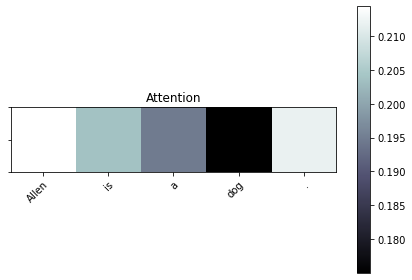

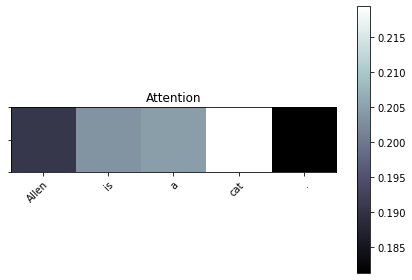

2020-09-13 16:51:24 INFO: matrix attention at layer 0


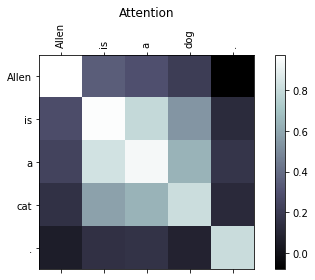

2020-09-13 16:51:24 INFO: matrix attention at layer 1


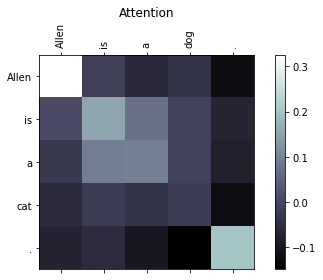

2020-09-13 16:51:24 INFO: matrix attention at layer 2


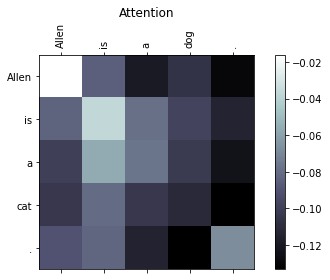

In [89]:
vis.visualize_json({
    "sentence1": "Allen is a dog.",
    "sentence2": "Allen is a cat.",
    "gold_label": "c"
})

# Model Loading + Demo

In [96]:
serialization_dir = "../param/GMN_BERT_300d_/"

In [103]:
from allennlp.common import Params
lm_config = Params.from_file(serialization_dir+"config.json")
lm_config
print(lm_config["model"])

model.Params({'classifier': {'activations': {'negative_slope': 0.2, 'type': 'leaky_relu'}, 'dropout': 0.1, 'hidden_dims': [300, 3], 'input_dim': 1200, 'num_layers': 2}, 'embedder': {'gradient_checkpointing': None, 'last_layer_only': True, 'max_length': None, 'model_name': 'bert-base-uncased', 'train_parameters': False, 'type': 'pretrained_transformer_mismatched'}, 'encoder': {'atts': {'bimpm': {'hidden_dim': 300, 'num_perspectives': 10, 'share_weights_between_directions': False, 'with_attentive_match': True, 'with_full_match': False, 'with_max_attentive_match': True, 'with_maxpool_match': True}, 'type': 'bimpm'}, 'convs': {'bias': False, 'in_channels': 300, 'num_relations': 20, 'out_channels': 300, 'root_weight': False, 'type': 'rgcn'}, 'num_layers': 3, 'pooler': {'gate_nn': {'activations': {'type': 'linear'}, 'dropout': 0, 'hidden_dims': 1, 'input_dim': 300, 'num_layers': 1}, 'nn': {'activations': {'type': 'linear'}, 'dropout': 0.1, 'hidden_dims': 300, 'input_dim': 300, 'num_layers': 

In [104]:
from allennlp.models import Model
#lm = Model.from_archive("../param
lm = Model.load(
    config = lm_config,
    serialization_dir = serialization_dir,
    weights_file = None, # use best by default
    cuda_device = -1
) 

ConfigurationError: key "updaters" is required at location "model.encoder."

In [94]:
lm_vocab = lm.vocab
lm_vocab

NameError: name 'lm' is not defined

In [105]:
predictor_load = GraphNLIPredictor(model = lm, dataset_reader=rdr_nlp)

NameError: name 'lm' is not defined

In [ ]:
att1h = lm(**batch, return_attention=True)["attentions"]["pooler2"][0]

In [ ]:
att1p = lm(**batch, return_attention=True)["attentions"]["pooler1"][0]

In [ ]:
dev2[0]

In [ ]:
show_sequence_attention(str1p, att1p)

In [ ]:
show_sequence_attention(str1h, att1p)

In [ ]:
def print_inst(inst):
    print(
        inst.fields["tokens_p"],
        inst.fields["tokens_h"],
        inst.fields["label"],
        sep='\n',
        )
print_inst(dev2[0])

In [ ]:
predictor_load.predict_batch_instance([dev2[0], dev2[1]]) # can return label(after modify code!)

In [ ]:
# two ways for model loading 
# params of config + .th

"""
components = run_config(CONFIG)
params = components['params']
dataset_reader = components['dataset_reader']
vocab = components['vocab']
model = components['model']


original_preds = make_predictions(model, dataset_reader)

# Save the model
serialization_dir = 'model'
config_file = os.path.join(serialization_dir, 'config.json')
vocabulary_dir = os.path.join(serialization_dir, 'vocabulary')
weights_file = os.path.join(serialization_dir, 'weights.th')

os.makedirs(serialization_dir, exist_ok=True)
params.to_file(config_file)
vocab.save_to_files(vocabulary_dir)
torch.save(model.state_dict(), weights_file)

# Load the model
loaded_params = Params.from_file(config_file)
loaded_model = Model.load(loaded_params, serialization_dir, weights_file)
loaded_vocab = loaded_model.vocab   # Vocabulary is loaded in Model.load()

# Make sure the predictions are the same
loaded_preds = make_predictions(loaded_model, dataset_reader)
assert original_preds == loaded_preds
print('predictions matched')

# Create an archive file
archive_model(serialization_dir, weights='weights.th')

# Unarchive from the file
archive = load_archive(os.path.join(serialization_dir, 'model.tar.gz'))

# Make sure the predictions are the same
archived_preds = make_predictions(archive.model, dataset_reader)
assert original_preds == archived_preds
print('predictions matched')
"""

In [106]:
from src.data_git.utils import text2graph, doc2graph
print(text2graph("The Big Apple is Newyork City", nlp))

Data(edge_attr=[20], edge_index=[2, 20], node_attr=[6], x=[6])


In [107]:
from allennlp.modules.token_embedders import ElmoTokenEmbedder
elmo_embedding = ElmoTokenEmbedder()

In [108]:
elmo_embedding.get_output_dim()

1024

In [6]:
import torch
from allennlp.data import Token, Vocabulary
from allennlp.data.fields import ListField, TextField
from allennlp.data.token_indexers import (
    SingleIdTokenIndexer,
    TokenCharactersIndexer,
    ELMoTokenCharactersIndexer,
    PretrainedTransformerIndexer,
    PretrainedTransformerMismatchedIndexer,
)
from allennlp.data.tokenizers import (
    CharacterTokenizer,
    PretrainedTransformerTokenizer,
    SpacyTokenizer,
    WhitespaceTokenizer,
)
from allennlp.modules.seq2vec_encoders import CnnEncoder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import (
    Embedding,
    TokenCharactersEncoder,
    ElmoTokenEmbedder,
    PretrainedTransformerEmbedder,
    PretrainedTransformerMismatchedEmbedder,
)
from allennlp.nn import util as nn_util

import warnings
warnings.filterwarnings("ignore")

In [18]:
from allennlp.data import TokenIndexer
from src.data_git import ELMoTokenCharactersIndexerWithMask
from src.modules import ElmoTokenEmbedderWithMask
tokenizer = WhitespaceTokenizer()
token_indexer = TokenIndexer.by_name("elmo_characters_with_mask")()
vocab = Vocabulary()
text = "This is some text."
#batch = ["This is some text.", "This is some other text."]
tokens = tokenizer.tokenize(text)
#tokens = tokenizer.tokenize(text)
print("ELMo tokens:", tokens)
text_field = TextField(tokens, {'tokens': token_indexer})
# print(vocab)
text_field.index(vocab=vocab)
token_tensor = text_field.as_tensor(text_field.get_padding_lengths())
print("ELMo tensors:", token_tensor)

# We're using a tiny, toy version of ELMo to demonstrate this.
elmo_options_file = 'https://allennlp.s3.amazonaws.com/models/elmo/test_fixture/options.json'
elmo_weight_file = 'https://allennlp.s3.amazonaws.com/models/elmo/test_fixture/lm_weights.hdf5'
elmo_embedding = ElmoTokenEmbedderWithMask(options_file=elmo_options_file,
                                   weight_file=elmo_weight_file)

embedder = BasicTextFieldEmbedder(token_embedders={'tokens': elmo_embedding})

tensor_dict = text_field.batch_tensors([token_tensor])
embedded_tokens = embedder(tensor_dict)
print("ELMo embedded tokens:", embedded_tokens)

ELMo tokens: [This, is, some, text.]
ELMo tensors: {'tokens': {'elmo_tokens': tensor([[259,  85, 105, 106, 116, 260, 261, 261, 261, 261, 261, 261, 261, 261,
         261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
         261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
         261, 261, 261, 261, 261, 261, 261, 261],
        [259, 106, 116, 260, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
         261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
         261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
         261, 261, 261, 261, 261, 261, 261, 261],
        [259, 116, 112, 110, 102, 260, 261, 261, 261, 261, 261, 261, 261, 261,
         261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
         261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
         261, 261, 261, 261, 261, 261, 261, 261],
        [259, 117, 102, 121, 117,  47, 260, 261, 261, 261, 26

In [19]:
embedded_tokens.shape

torch.Size([1, 4, 32])

In [ ]:
model_name = "bert-base-cased"
transformer_indexer = PretrainedTransformerMismatchedIndexer(model_name=model_name)
transformer_embedder = PretrainedTransformerMismatchedEmbedder(model_name=model_name)